In [1]:
import os.path

import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import umap
from tqdm import tqdm
from hipposlam.VAE import EmbeddingImageDatasetAll, VAELearner, convert_to_embed
import torch
from torch.utils.data import DataLoader
import pickle

In [2]:
class OfflineEmbeddingLearner:
    def __init__(self, lowSThresh):

        self.lowSThresh = lowSThresh
        self.sid2embed = []

    def observe(self, e_new, emins, emaxs):
        # Initial condition
        if len(self.sid2embed) == 0:
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 0

        e_mat = np.stack(self.sid2embed)  # -> (Nstates, Embed_dim)

        # # Cosine similarity. (Embed_dim, ) @ (Nstates, Embed_dim).T -> (Nstates, )
        # cossim = e_new @ (e_mat.T) / (np.linalg.norm(e_new) * np.linalg.norm(e_mat, axis=-1) + 1e-9)
        # sim_measure = cossim
        sim_measure = self.prenorm_eudist(e_new, e_mat, emins, emaxs)
        maxid = np.argmax(sim_measure)
        maxcossim = sim_measure[maxid]

        if (maxcossim < self.lowSThresh):  # Not matching any existing embeddings
            # Create a new state, and remember the embedding
            self.sid2embed.append(e_new.copy())
            return len(self.sid2embed) - 1, 1

        else:
            return maxid, maxcossim


    def prenorm_eudist(self, e_new, e_mat, emins, emaxs):

        e_new = (e_new - emins) / (emaxs - emins)
        e_mat = (e_mat - emins) / (emaxs - emins)
        eusim = 1 - np.sqrt(np.sum(np.square(e_new.reshape(1, -1) - e_mat), axis=1))/np.sqrt(2)
        return eusim

In [3]:
# Load data
project_dir = join('data', 'VAE')
load_embed_dir = join(project_dir, 'embeds')
load_annotation_pth = join(project_dir, 'annotations.csv')
save_dir = join(project_dir, 'model', 'OnlyEmbed_imgs3')
save_umap_pth = join(save_dir, 'umap.sav')
dataset = EmbeddingImageDatasetAll(load_annotation_pth, load_embed_dir, to_numpy=True)
# MNembeds = np.stack([e for e, _ in dataset])
# labels = np.stack([e for _, e in dataset])

N = len(dataset)
embeds, labels = dataset.get_all()
embeds_fit, labels_fit = embeds[:N], labels[:N]

In [4]:
import joblib
# Fit and transform umap
nneigh = 10
min_dist = 0.9
metric = 'euclidean'

umap_model = umap.UMAP(n_neighbors=nneigh,
                       min_dist=min_dist,
                       metric=metric,
                       n_components=2)
umap_embeds_fit = umap_model.fit_transform(embeds_fit)
umap_embeds = umap_model.transform(embeds)

joblib.dump(umap_model, save_umap_pth)

['data\\VAE\\model\\OnlyEmbed_imgs3\\umap.sav']

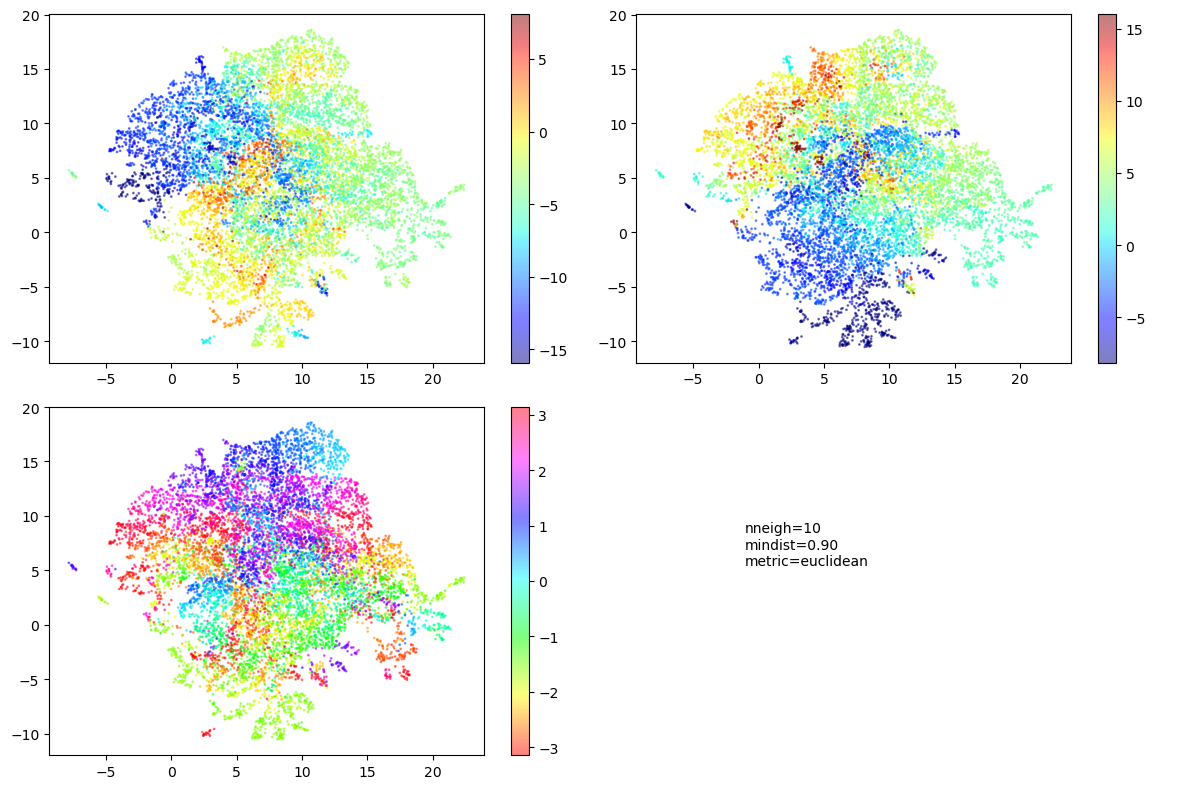

In [5]:
# Plot Umap
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()
im0 = ax[0].scatter(umap_embeds[:, 0], umap_embeds[:, 1], s=1, c=labels[:, 0], cmap='jet', alpha=0.5)
plt.colorbar(im0, ax=ax[0])
im1 = ax[1].scatter(umap_embeds[:, 0], umap_embeds[:, 1], s=1, c=labels[:, 1], cmap='jet', alpha=0.5)
plt.colorbar(im1, ax=ax[1])
im2 = ax[2].scatter(umap_embeds[:, 0], umap_embeds[:, 1], s=1, c=labels[:, 2], cmap='hsv', alpha=0.5)
plt.colorbar(im2, ax=ax[2])
txt = f'nneigh={nneigh}\nmindist={min_dist:0.2f}\nmetric={metric}\n'
ax[3].annotate(text=txt, xy=(0.2, 0.5), xycoords='axes fraction')
ax[3].axis('off')
fig.tight_layout()
fig.savefig(join(save_dir, 'UmapEmbeddingCheck.png'), dpi=300)
# plt.close(fig)


In [6]:
umins = umap_embeds_fit.min(axis=0)
umaxs = umap_embeds_fit.max(axis=0)
lowSThresh = 0.98
oel = OfflineEmbeddingLearner(lowSThresh=lowSThresh)
Niters = 10000
sid = np.zeros(Niters)
sval = np.zeros(Niters)
obsnum = np.zeros(Niters)
for i in tqdm(range(Niters)):
    sid[i], sval[i] = oel.observe(umap_embeds[i, :], umins, umaxs)
    obsnum[i] = len(oel.sid2embed)




100%|██████████| 10000/10000 [00:08<00:00, 1190.53it/s]


Number of unique states = 400


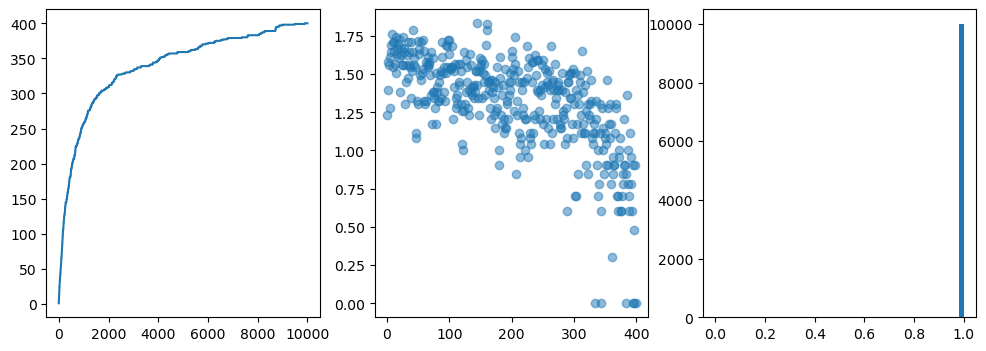

In [7]:
unique_sids, unique_counts = np.unique(sid, return_counts=True)
print('Number of unique states = %d'%(unique_sids.shape[0]))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(obsnum)
ax[1].scatter(unique_sids, np.log10(unique_counts), alpha=0.5)
_ = ax[2].hist(sval, bins=50)

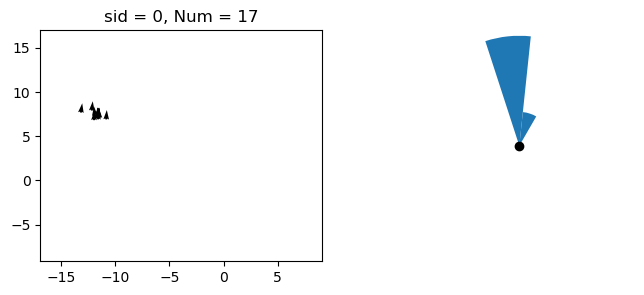

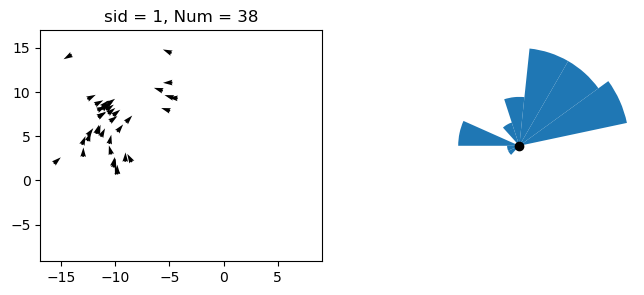

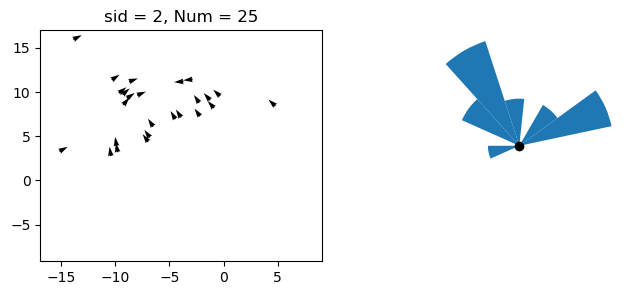

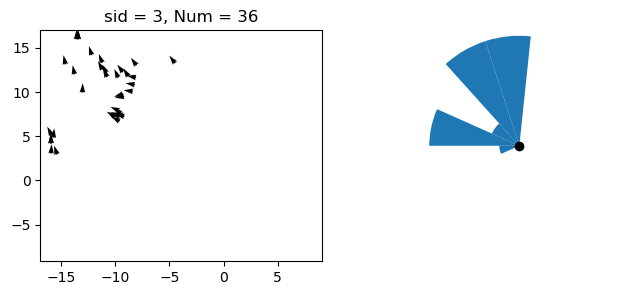

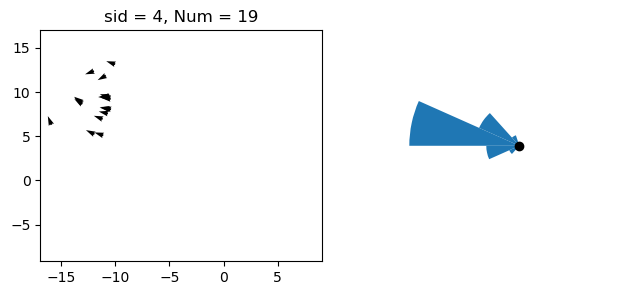

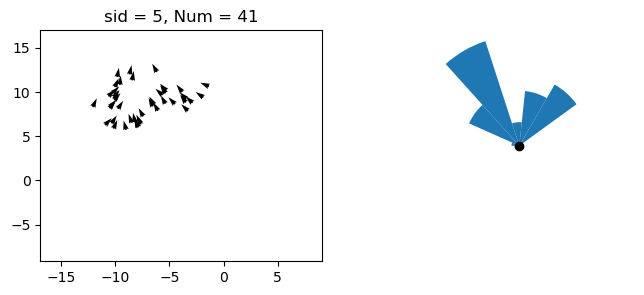

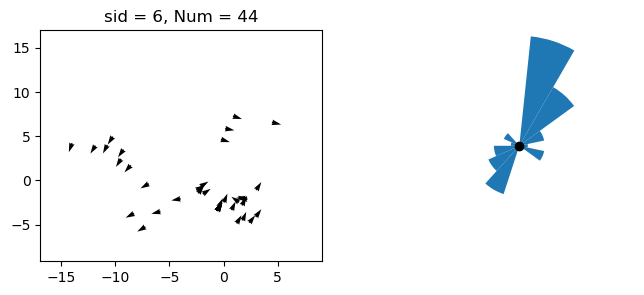

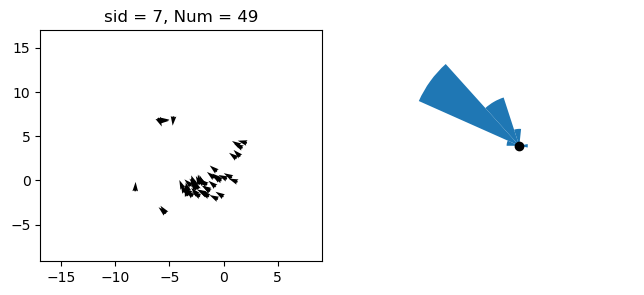

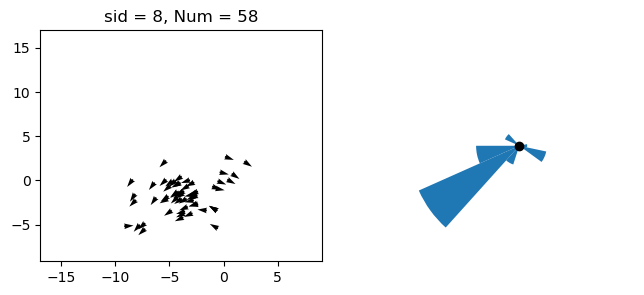

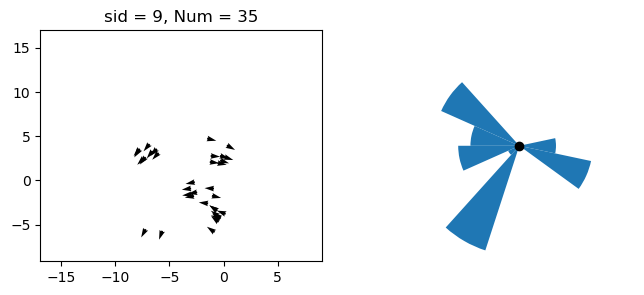

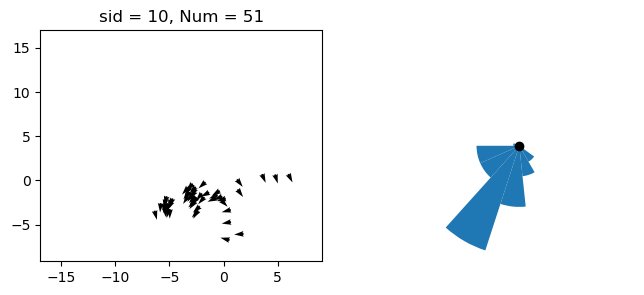

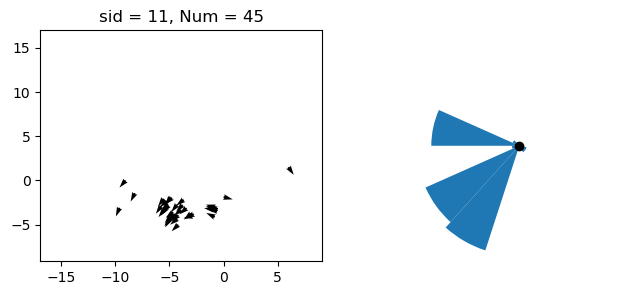

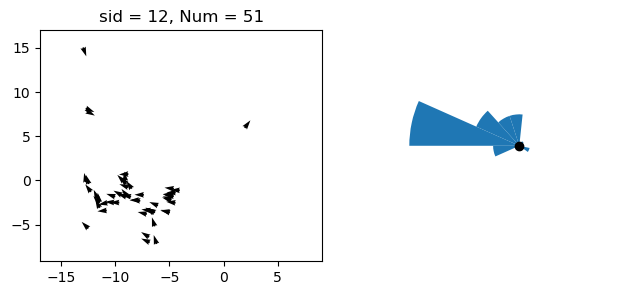

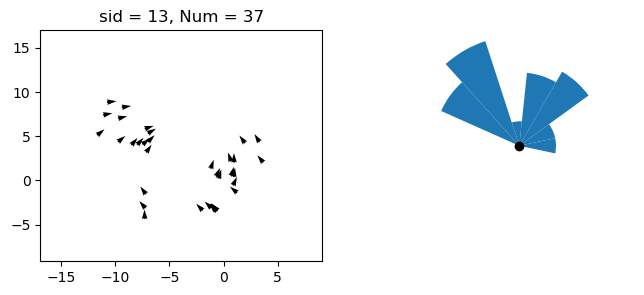

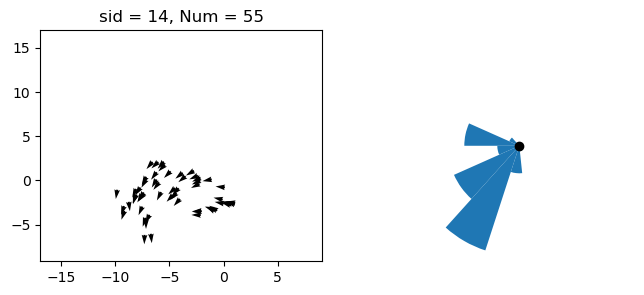

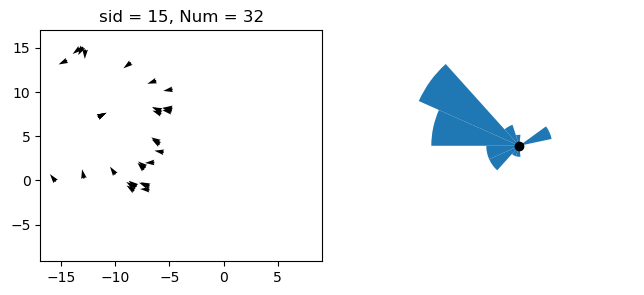

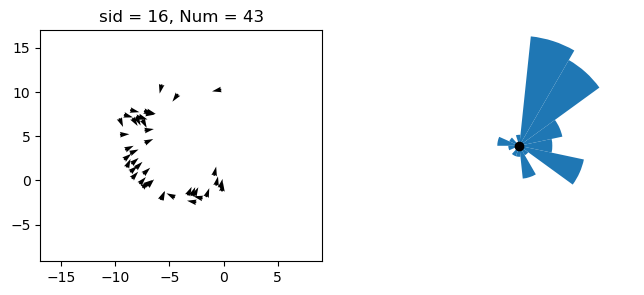

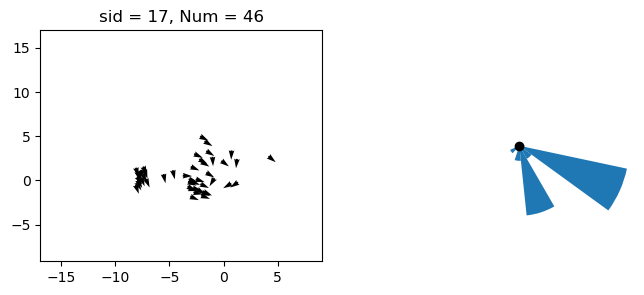

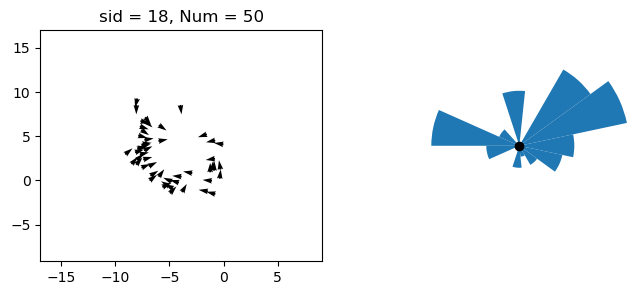

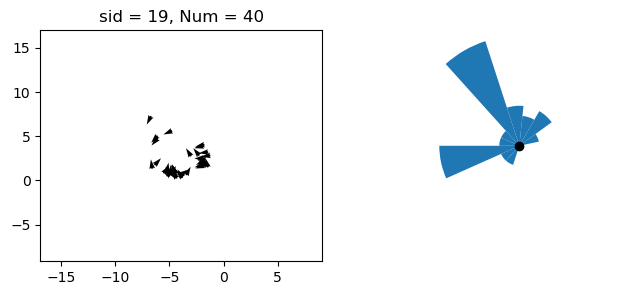

In [19]:
labels = dataset.img_labels[['x', 'y', 'a']].to_numpy()
x, y, a = labels[:Niters, 0], labels[:Niters, 1], labels[:Niters, 2]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

unique_sids = np.unique(sid)
np.random.seed(11)

selected_sids = np.random.choice(len(unique_sids), 20, replace=False)
# for sid_each in np.append(selected_sids, 0):
aedges = np.linspace(-np.pi, np.pi, 16)
axm = aedges[:-1]/ 2 + aedges[1:] / 2
ax0_margin = 1
for sid_each in np.arange(0, 20):
    mask = sid == sid_each
    xplot = x[mask]
    yplot = y[mask]
    aplot = a[mask]


    fig = plt.figure(figsize=(8, 3))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2, projection='polar')


    ax0.quiver(xplot, yplot, np.cos(aplot), np.sin(aplot), scale=30)
    ax0.set_xlim(xmin- ax0_margin, xmax + ax0_margin)
    ax0.set_ylim(ymin- ax0_margin, ymax + ax0_margin)
    ax0.set_title('sid = %d, Num = %d'%(sid_each, mask.sum()))

    abins,_  = np.histogram(aplot, bins=aedges )
    ax1.bar(axm, abins, width=aedges[1]-aedges[0])
    ax1.scatter(0, 0, c='k')
    ax1.axis('off')



